In [1]:
import sentinel_collection as sc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import planetary_computer
import s2_functions
import xarray as xr
import pandas as pd
import geopandas as gpd
import pystac_client
import stackstac
import dask

In [2]:
aoi = gpd.read_file('../../2_data/Koumbia_db/Koumbia_JECAM_2018-20-21.shp')
aoi = aoi.to_crs('EPSG: 4326')
bbox = aoi.total_bounds
bands = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']
year = '2018'
time = year + '-01-01/' + year + '-12-31'

In [3]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
    )

In [4]:
s2_search_all = catalog.search(
        collections=["sentinel-2-l2a"],
        bbox= bbox,
        datetime= time,
        query={'eo:cloud_cover': {"lt": 100}, 
                's2:nodata_pixel_percentage': {'lt': 50},
                's2:mgrs_tile': {'eq': '30PVT'}},
        )

In [5]:
complete_item = s2_search_all.item_collection()

In [6]:

petite_bbox = [415000, 1240000, 415000+1000, 1240000+1000]

In [7]:
stack = stackstac.stack(complete_item, resolution = 10, bounds = petite_bbox, chunksize= (69, 1, 100, 100))

/Users/edgar/opt/anaconda3/envs/GeoDS/lib/python3.11/site-packages/stackstac/accumulate_metadata.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(


In [8]:
stack

<xarray.DataArray 'stackstac-da5eedd6382264116633c8a890c67a09' (time: 69,
                                                                band: 17,
                                                                y: 100, x: 100)>
dask.array<fetch_raster_window, shape=(69, 17, 100, 100), dtype=float64, chunksize=(69, 1, 100, 100), chunktype=numpy.ndarray>
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 2018-01-05...
    id                                       (time) <U54 'S2A_MSIL2A_20180105...
  * band                                     (band) <U7 'AOT' ... 'preview'
  * x                                        (x) float64 4.15e+05 ... 4.16e+05
  * y                                        (y) float64 1.241e+06 ... 1.24e+06
    s2:granule_id                            (time) <U62 'S2A_OPER_MSI_L2A_TL...
    ...                                       ...
    gsd                                      (band) object 10.0 60.0 ... None
    title                                    (band) <U37 'Aerosol optical thi...
    common_name                              (band) object None ... None
    center_wavelength                        (band) object None 0.443 ... None
    full_width_half_max                      (band) object None 0.027 ... None
    epsg                                     int64 32630
Attributes:
    spec:        RasterSpec(epsg=32630, bounds=(415000, 1240000, 416000, 1241...
    crs:         epsg:32630
    transform:   | 10.00, 0.00, 415000.00|\n| 0.00,-10.00, 1241000.00|\n| 0.0...
    resolution:  10

In [9]:
SCL = stack.sel(band = 'SCL')

In [10]:
cirrus = xr.where(SCL == 10, 1, 0) # cirrus pixels, binary mask 0, 1
highclouds = xr.where(SCL == 9, 1, 0) # High probability clouds, binary mask 0, 1
medclouds = xr.where(SCL == 8, 1, 0) # Medium probability clouds, binary mask 0, 1
unclass = xr.where(SCL == 7, 1, 0) # unclassified pixels, binary mask 0, 1
shaclouds = xr.where(SCL == 3, 1, 0) # Cloud shadows, binary mask 0, 1
saturated = xr.where(SCL == 1, 1, 0) # saturated pixels, binary mask 0, 1

## mannually check quality of final interpolation

mask = highclouds + medclouds + shaclouds + saturated + cirrus + unclass # Mask, binary mask 0, 1

In [11]:
hcpixels = ((highclouds.sum(axis = (1, 2)) / (highclouds.shape[1] * highclouds.shape[2]))*100).compute()
mcpixels = ((medclouds.sum(axis = (1, 2)) / (highclouds.shape[1] * highclouds.shape[2]))*100).compute()
scpixels = ((shaclouds.sum(axis = (1, 2)) / (highclouds.shape[1] * highclouds.shape[2]))*100).compute()
satpixels = ((saturated.sum(axis = (1, 2)) / (highclouds.shape[1] * highclouds.shape[2]))*100).compute()
cirpixels = ((cirrus.sum(axis = (1, 2)) / (highclouds.shape[1] * highclouds.shape[2]))*100).compute()
ucpixels = ((unclass.sum(axis = (1, 2)) / (highclouds.shape[1] * highclouds.shape[2]))*100).compute()
maskedpixels = ((mask.sum(axis = (1, 2)) / (highclouds.shape[1] * highclouds.shape[2]))*100).compute()

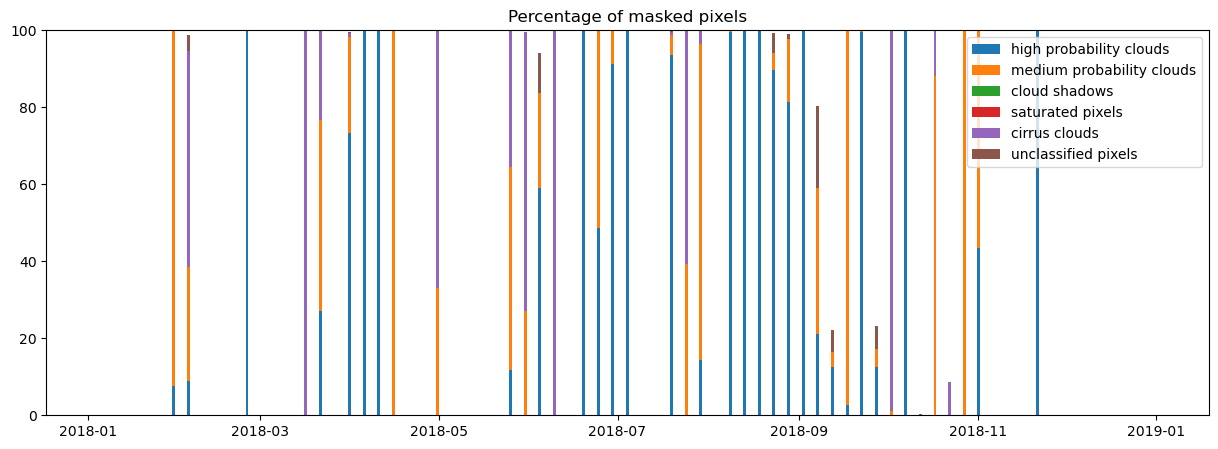

In [12]:
values = {
    'high probability clouds': hcpixels.values,
    'medium probability clouds': mcpixels.values,
    'cloud shadows': scpixels.values,
    'saturated pixels': satpixels.values,
    'cirrus clouds': cirpixels.values,
    'unclassified pixels': ucpixels.values
}

width = 1

fig, ax = plt.subplots(figsize = (15, 5))
bottom = np.zeros(69)

for pixeltype, weight_count in values.items():
    p = ax.bar(hcpixels.indexes['time'], weight_count, width, label=pixeltype, bottom=bottom)
    bottom += weight_count

ax.set_title("Percentage of masked pixels")
ax.legend(loc="upper right")

plt.show()

In [14]:
hcpixels.where(hcpixels.indexes['time'] == '2018-02-24T10:30:21.026000000').dropna('time')

<xarray.DataArray 'stackstac-da5eedd6382264116633c8a890c67a09' (time: 1)>
array([100.])
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 2018-02-24...
    id                                       (time) <U54 'S2A_MSIL2A_20180224...
    band                                     <U7 'SCL'
    s2:granule_id                            (time) <U62 'S2A_OPER_MSI_L2A_TL...
    s2:nodata_pixel_percentage               (time) float64 0.0
    s2:water_percentage                      (time) float64 0.0
    ...                                       ...
    gsd                                      object 20.0
    title                                    <U37 'Scene classfication map (S...
    common_name                              object None
    center_wavelength                        object None
    full_width_half_max                      object None
    epsg                                     int64 32630

In [15]:
mask

<xarray.DataArray 'stackstac-da5eedd6382264116633c8a890c67a09' (time: 69,
                                                                y: 100, x: 100)>
dask.array<add, shape=(69, 100, 100), dtype=int64, chunksize=(69, 100, 100), chunktype=numpy.ndarray>
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 2018-01-05...
    id                                       (time) <U54 'S2A_MSIL2A_20180105...
    band                                     <U7 'SCL'
  * x                                        (x) float64 4.15e+05 ... 4.16e+05
  * y                                        (y) float64 1.241e+06 ... 1.24e+06
    s2:granule_id                            (time) <U62 'S2A_OPER_MSI_L2A_TL...
    ...                                       ...
    gsd                                      object 20.0
    title                                    <U37 'Scene classfication map (S...
    common_name                              object None
    center_wavelength                        object None
    full_width_half_max                      object None
    epsg                                     int64 32630

In [16]:
maskedstack = stack.where(mask == 0, np.nan)

In [17]:
interpolate_stack = maskedstack.interpolate_na(dim="time", method="linear", use_coordinate = 'time')

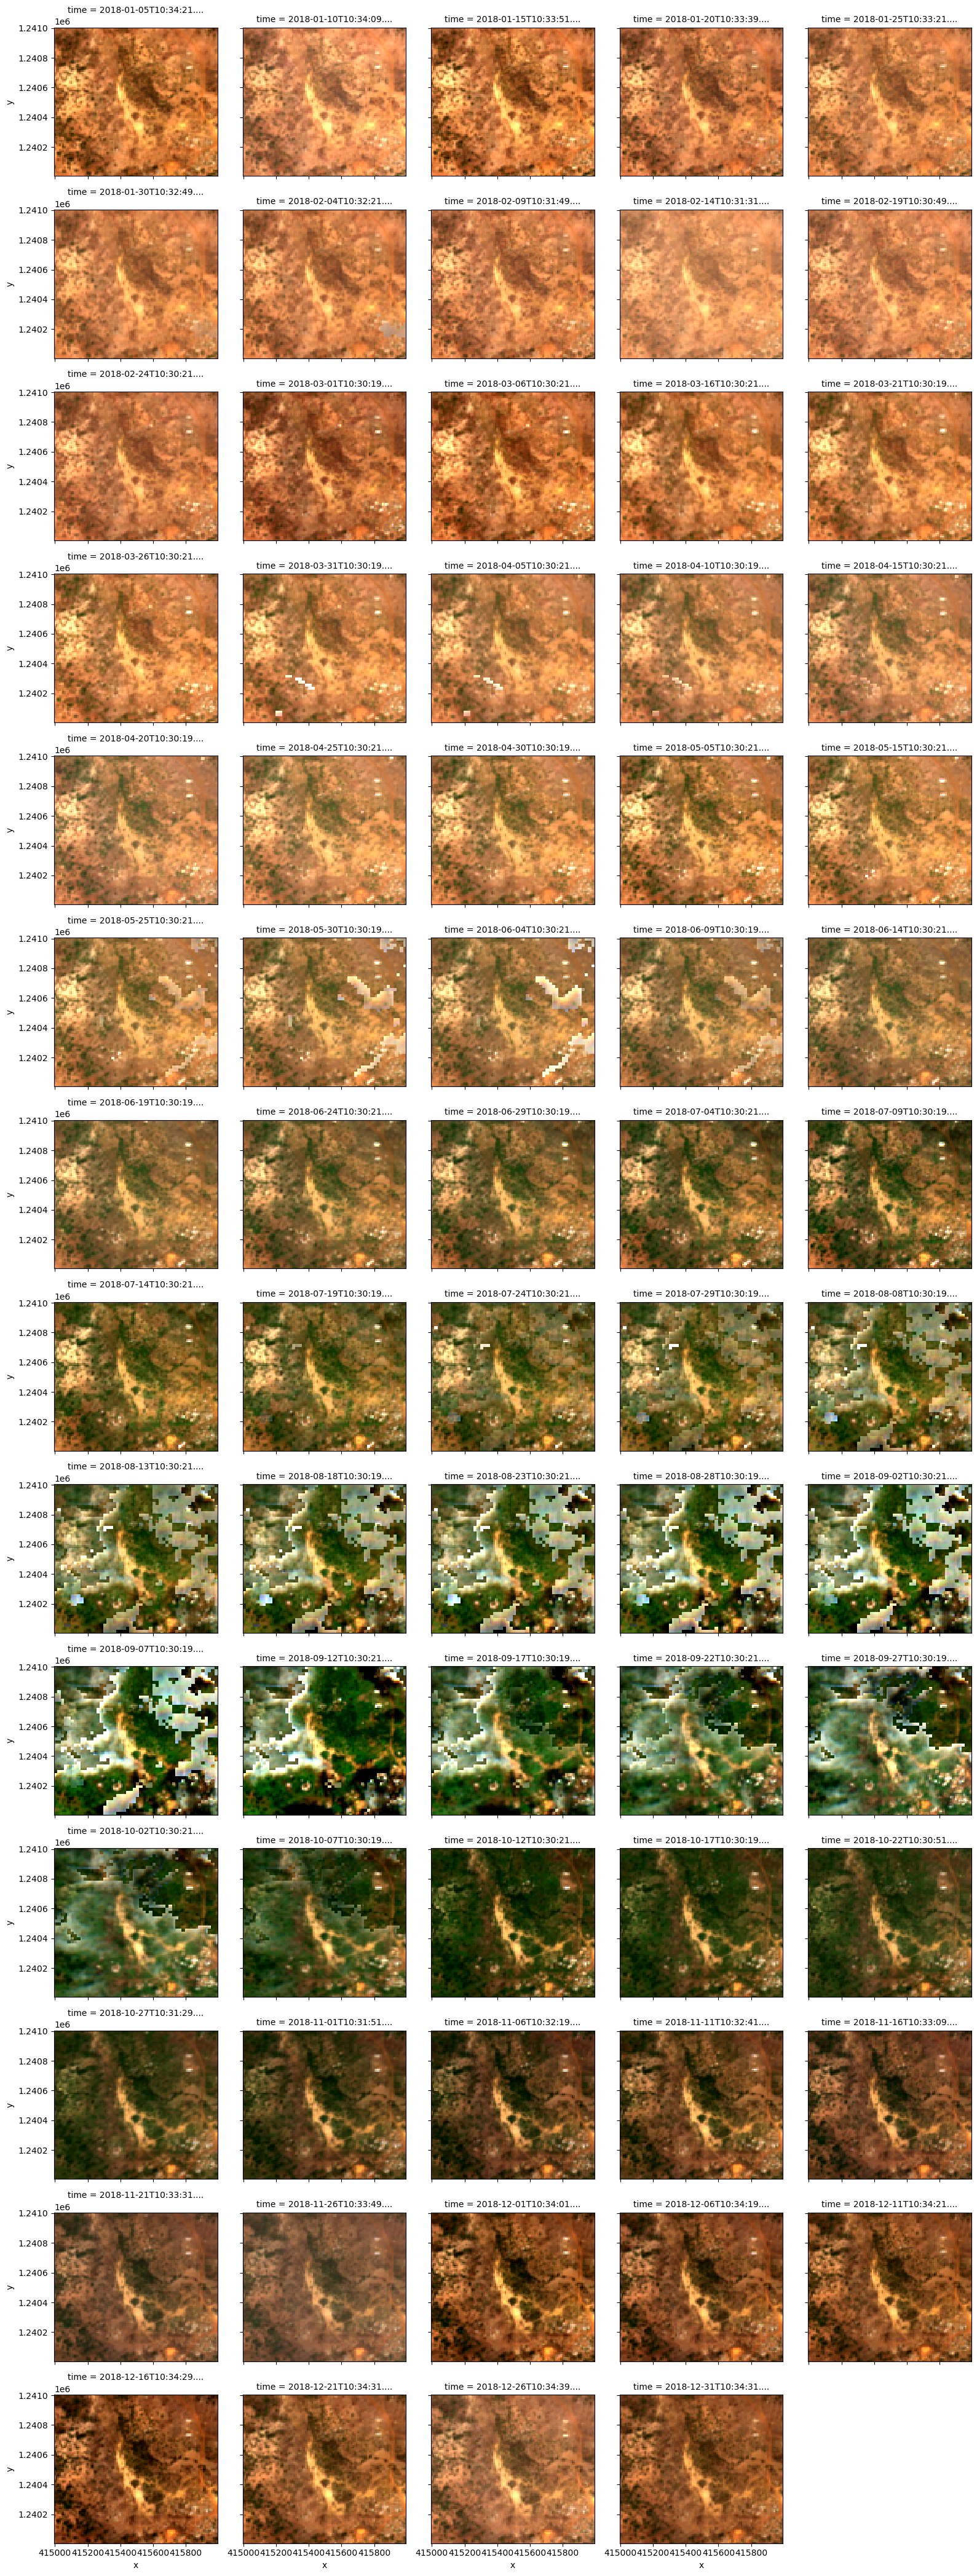

In [18]:
interpolate_stack.sel(band = ['B04', 'B03', 'B02']).plot.imshow(rgb="band", col="time", col_wrap=5, robust=True)

In [72]:
SCL.sel(time = slice('2018-09-07T10:30:19.024000000', '2018-09-07T10:30:19.024000000'))

<xarray.DataArray 'stackstac-ac6c4dfedc2202ebdb4b67fb208b9c28' (time: 1,
                                                                y: 100, x: 100)>
dask.array<getitem, shape=(1, 100, 100), dtype=float64, chunksize=(1, 100, 100), chunktype=numpy.ndarray>
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 2018-09-07...
    id                                       (time) <U54 'S2B_MSIL2A_20180907...
    band                                     <U7 'SCL'
  * x                                        (x) float64 4.15e+05 ... 4.16e+05
  * y                                        (y) float64 1.241e+06 ... 1.24e+06
    s2:saturated_defective_pixel_percentage  float64 0.0
    ...                                       ...
    proj:transform                           object [20.0, 0.0, 399960.0, 0.0...
    gsd                                      object 20.0
    common_name                              object None
    center_wavelength                        object None
    full_width_half_max                      object None
    epsg                                     int64 32630
Attributes:
    spec:        RasterSpec(epsg=32630, bounds=(415000, 1240000, 416000, 1241...
    crs:         epsg:32630
    transform:   | 10.00, 0.00, 415000.00|\n| 0.00,-10.00, 1241000.00|\n| 0.0...
    resolution:  10

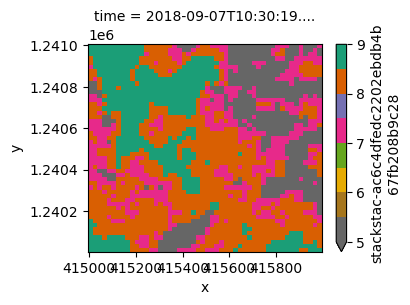

In [74]:
SCL.sel(time = slice('2018-09-07T10:30:19.024000000', '2018-09-07T10:30:19.024000000')).plot.imshow(col = 'time', robust=True, cmap = 'Dark2_r')

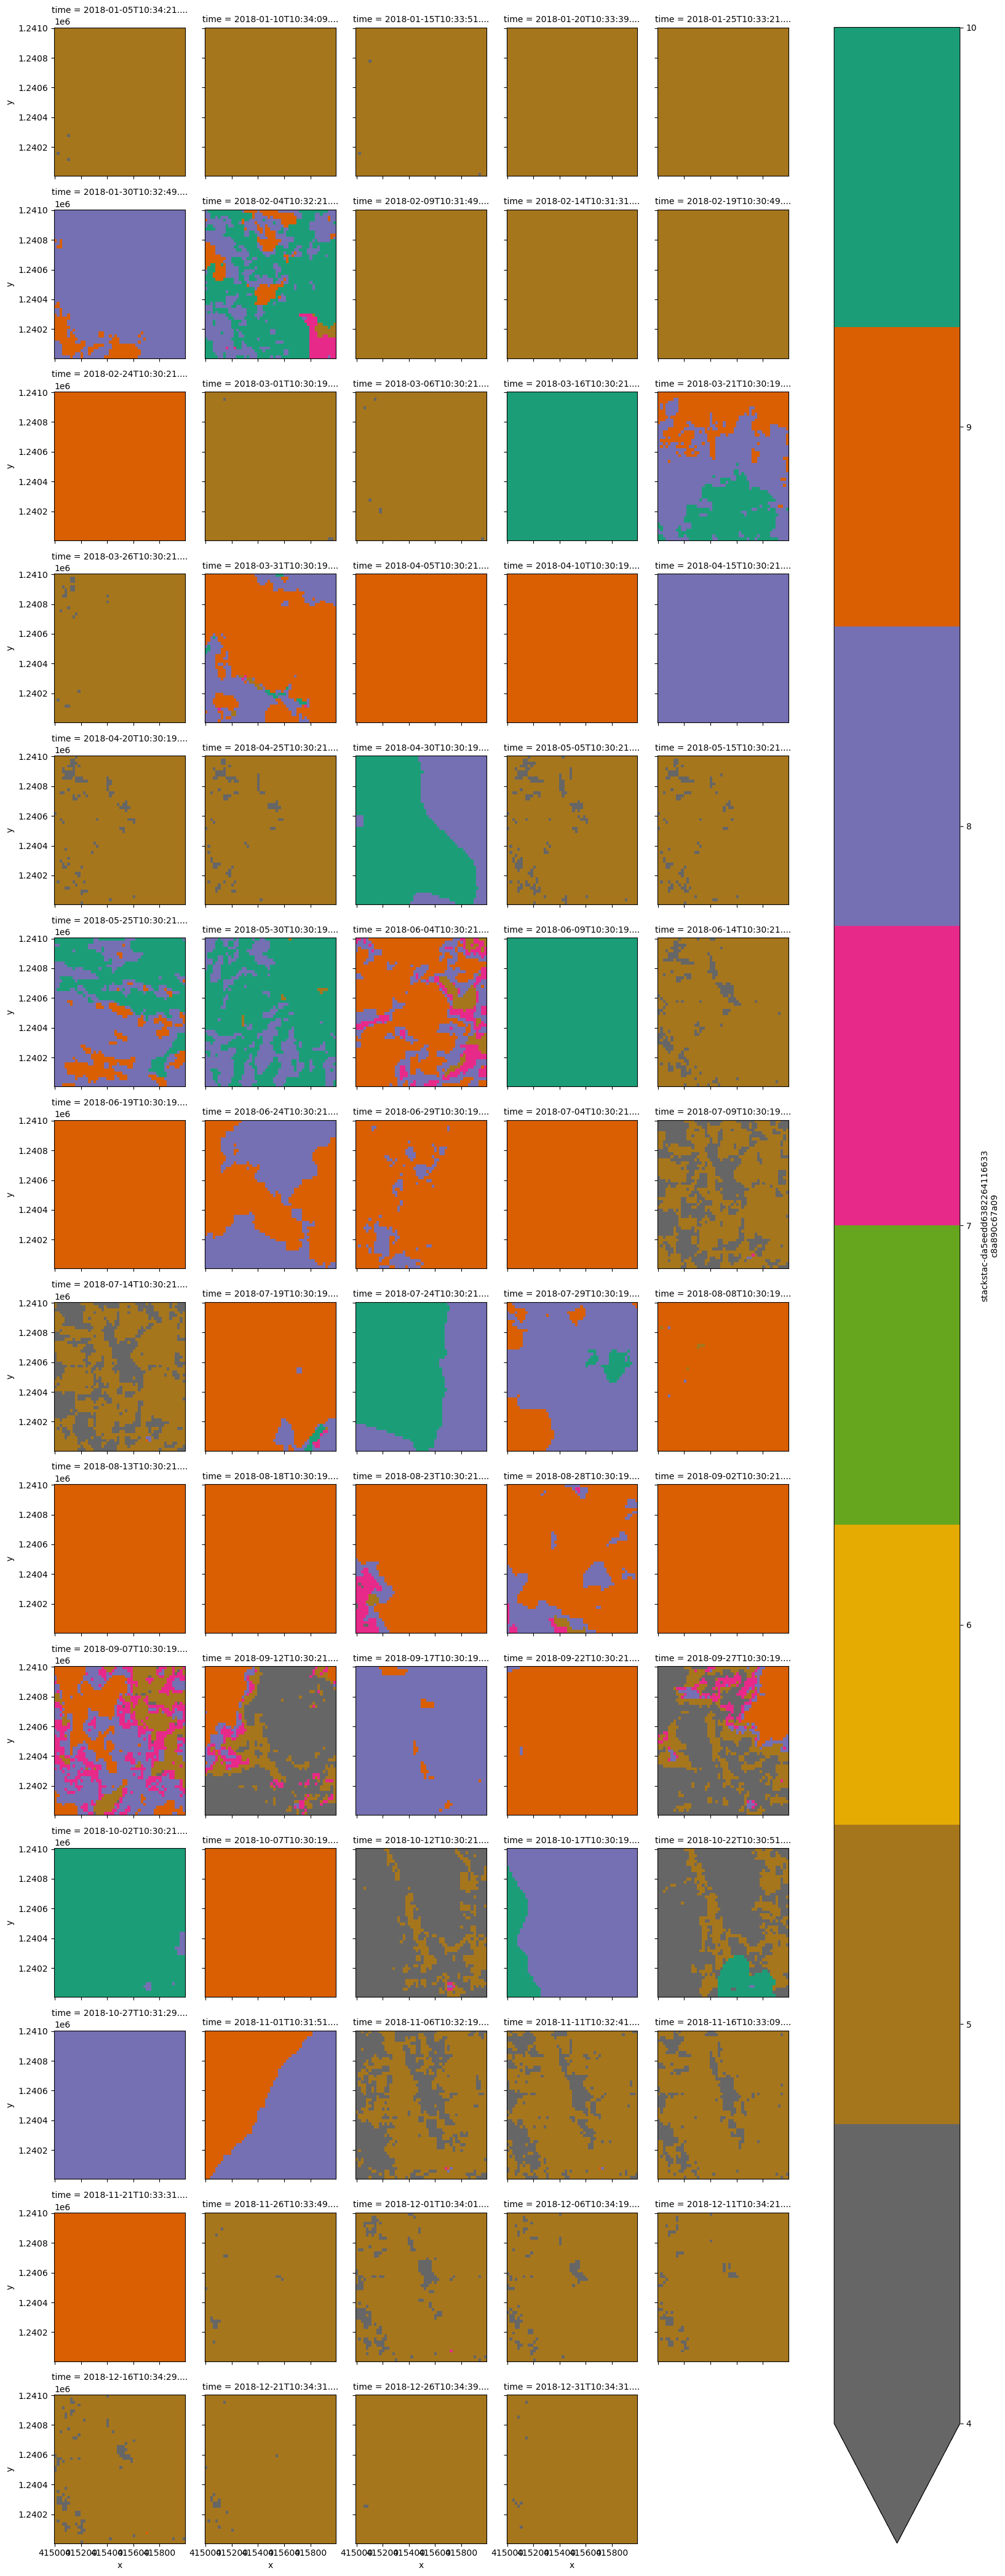

In [19]:
SCL.plot.imshow(col="time", col_wrap=5, robust=True, cmap = 'Dark2_r')

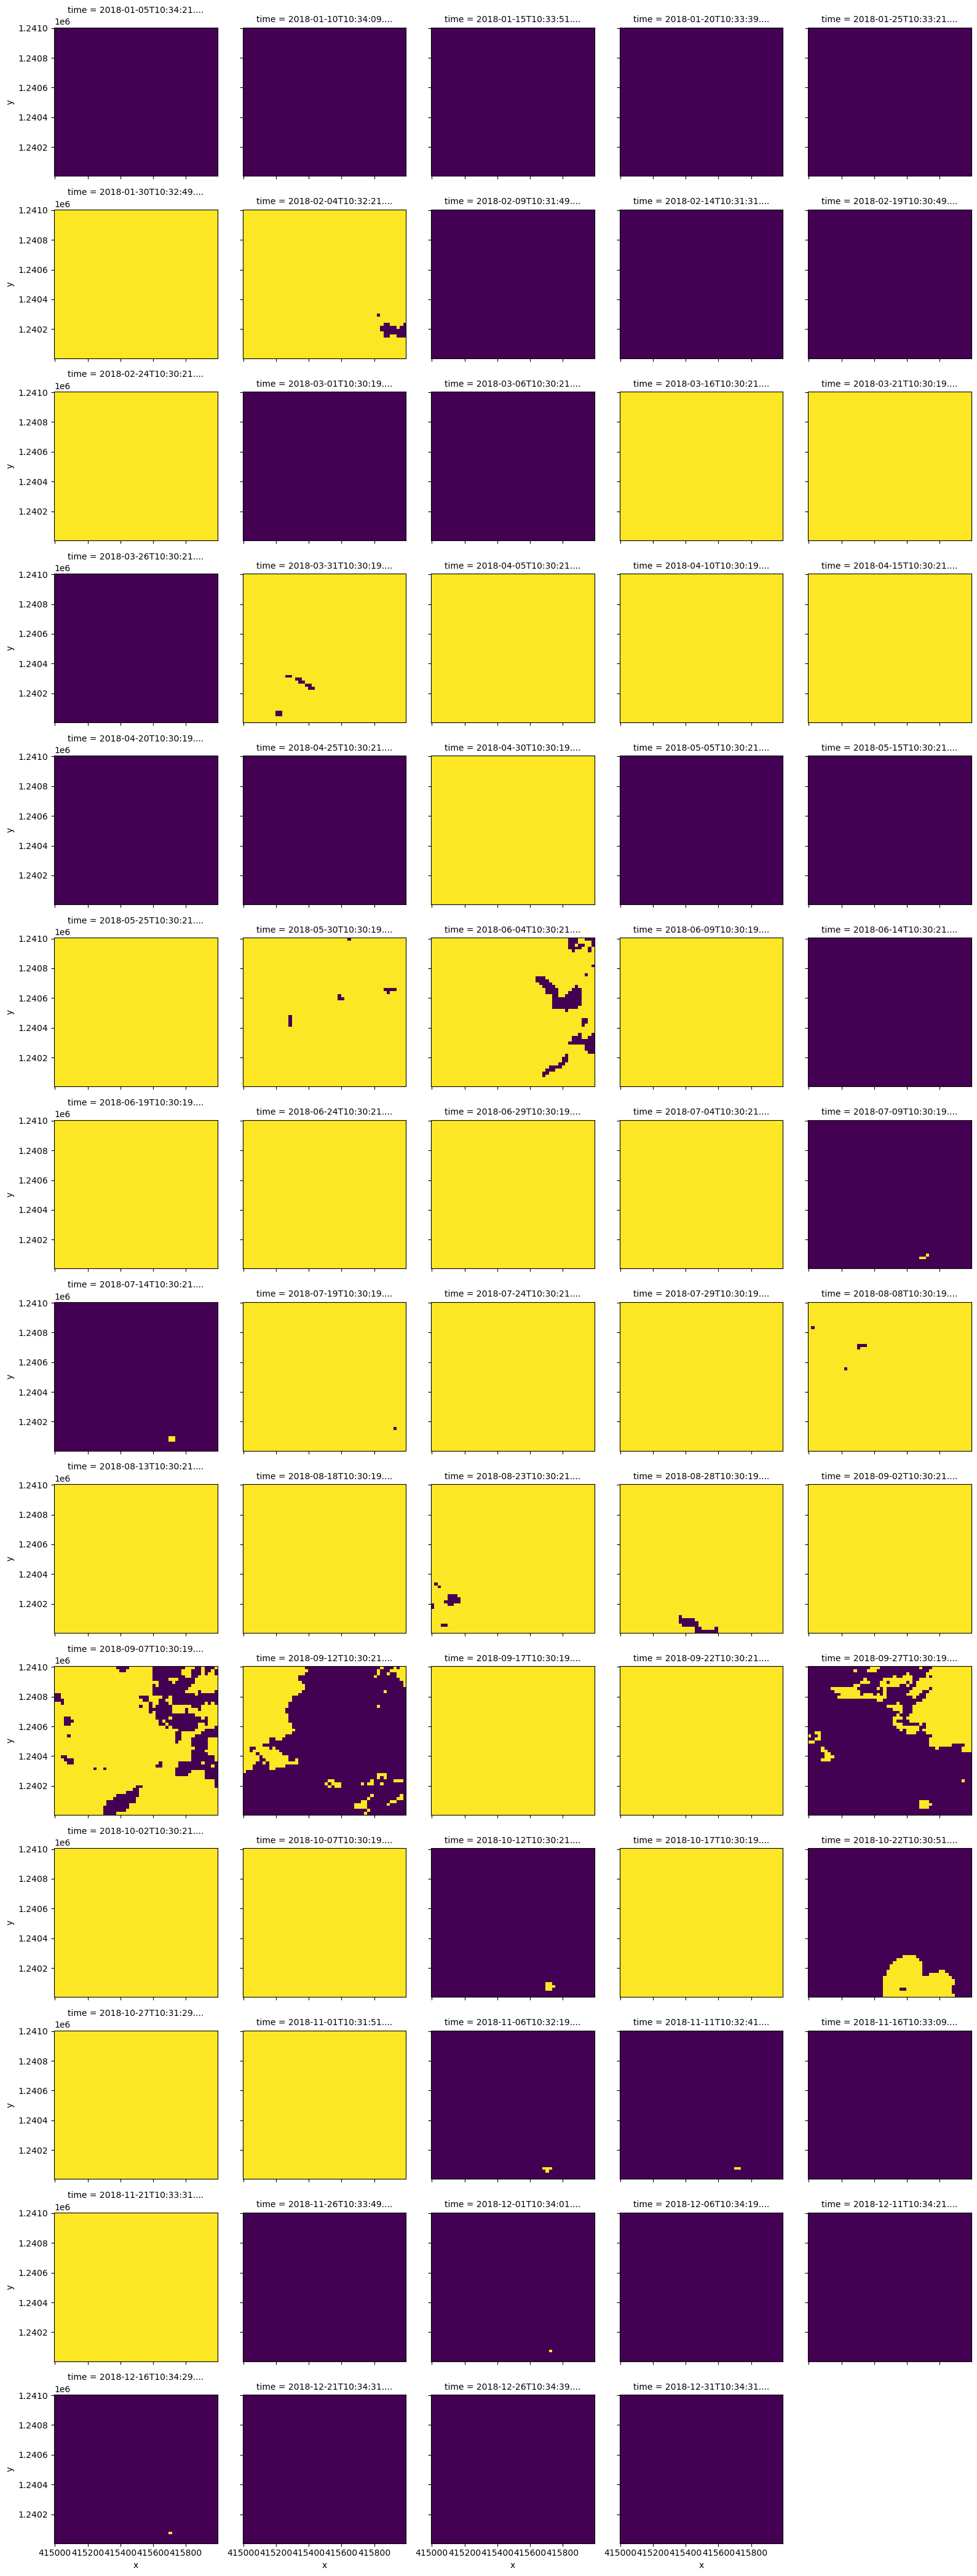

In [20]:
mask.plot.imshow(col="time", col_wrap=5, robust=True, add_colorbar=False)